I've been interested in using machine learning to understand more about dating habits. Fortunately, I found a dataset on OKCupid collected by Kirkegaard and Bjerrekaer (https://figshare.com/articles/dataset/OKCupid_Datasets/14987388). It features 68371 records with information collected on how they've answered questions and some innate scores that OKCupid gives each profile. There's already been plenty of work done regarding this dataset, so I want to focus on something more niche.

To start, the data is present in two files; one file for question indexes and one with the indexed data. Let's load the data in!

In [1]:
# Imports first as usual
import pandas as pd
from sklearn.cluster import Birch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import optuna
import shap
import matplotlib
from IPython.display import display
import matplotlib.pyplot as plt


data = pd.read_parquet("D:\\portfolio\\data\\parsed_data_public.parquet")
questions = pd.read_csv("D:\\portfolio\\data\\question_data.csv", delimiter=";", index_col=0)
data.set_index("Unnamed: 0", inplace = True)
display(data.head())
display(data.shape)
display(questions.head())
display(questions.shape)

c:\Users\44790\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86615,q86699,q363047,CA,gender_orientation,gender,race,gender2,gender2_num,CA_items
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,None,Horrified,None,None,None,None,No,None,None,None,...,None,None,None,0.763080,Hetero_female,Woman,White,Woman,0.0,4
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,NaN,Hetero_male,Man,None,Man,1.0,0
3,None,None,None,No,No,None,No,None,None,None,...,None,None,None,0.661309,Hetero_female,Woman,None,Woman,0.0,7
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,NaN,Hetero_female,Woman,White,Woman,0.0,0
5,None,None,None,None,None,None,None,None,None,None,...,None,None,None,0.875424,Bisexual_female,Woman,None,Woman,0.0,3


(68371, 2625)

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


(2620, 9)

There are quite a lot of questions - 2620! Let's get some more information on what the questions look like.

In [2]:
keywords = set(questions.Keywords)
keywords.remove(np.NaN)
print(keywords)

{'politics; sex/intimacy; religion/superstition; opinion', 'descriptive; preference', 'politics; opinion; cognitive', 'sex/intimacy; preference', 'religion/superstition; opinion; cognitive', 'politics; cognitive', 'religion/superstition; descriptive', 'politics; religion/superstition; preference', 'politics; preference; descriptive', 'politics; descriptive', 'politics', 'preference; descriptive; opinion', 'sex/intimacy; preference; BDSM', 'preference; technology', 'sex/intimacy', 'religion/superstition; opinion', 'politics; preference', 'opinion; technology', 'politics; opinion; technology', 'religion/superstition; preference', 'religion/superstition', 'preference; opinion', 'sex/intimacy; preference; descriptive', 'politics; preference; opinion; sex/intimacy', 'religion/superstition; descriptive; preference', 'descriptive; technology', 'sex/intimacy; religion/superstition; preference', 'sex/intimacy; descriptive', 'descriptive; opinion', 'preference', 'preference; descriptive; technol

There are some themes amongst the questions. I'm most interested in how politics influences some of the descriptive traits that OKCupid has gathered. To reduce the number of features we're fitting with, I'll only select to top 7 most answered politics questions.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68371 entries, 1 to 68371
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   q179268  54202 non-null  object
 1   q403     52369 non-null  object
 2   q175     45720 non-null  object
 3   q212813  45107 non-null  object
 4   q612     44907 non-null  object
 5   q838     44461 non-null  object
 6   q27921   42307 non-null  object
 7   q20519   40256 non-null  object
 8   q85835   38702 non-null  object
 9   q37708   37661 non-null  object
dtypes: object(10)
memory usage: 5.7+ MB


None

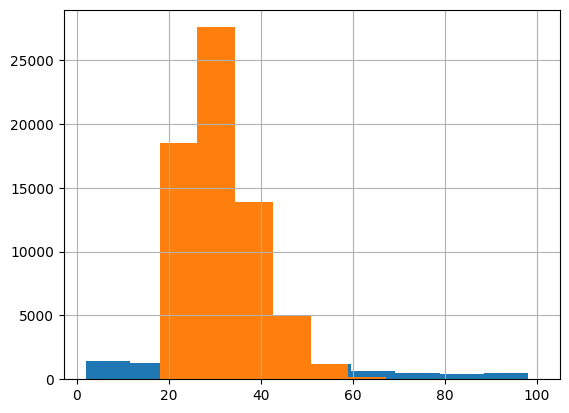

In [3]:
politics = [x for x in keywords if x.startswith("politics")]
question_subset = questions[questions["Keywords"].isin(politics)]
top_politics = question_subset.sort_values("N", ascending=False).iloc[0:10]
data["p_honest"].hist()
data["d_age"].hist()
display(data[top_politics.index].info())

The descriptive properties are denoted with "p_". We can take a look at all of the potential targets to use politics questions to predict.

In [4]:
descriptives = [column for column in data.columns if column.startswith("p_")]
print(descriptives)

['p_conf', 'p_laidback', 'p_drug', 'p_lit', 'p_progress', 'p_roman', 'p_dominant', 'p_polit', 'p_pure', 'p_manners', 'p_submissive', 'p_inde', 'p_kinky', 'p_opti', 'p_sloppy', 'p_indie', 'p_introvert', 'p_arro', 'p_ambi', 'p_cool', 'p_trusting', 'p_thrift', 'p_organ', 'p_sexdrive', 'p_honest', 'p_expsex', 'p_artsy', 'p_scien', 'p_spon', 'p_explife', 'p_greed', 'p_capi', 'p_giving', 'p_explove', 'p_convenmoral', 'p_aggre', 'p_kind', 'p_extro', 'p_friendstrangers', 'p_oldfash', 'p_comp', 'p_lovedri', 'p_sprit', 'p_passion', 'p_energetic', 'p_exer', 'p_logic', 'p_math', 'p_geeky', 'p_adven']


I'm planning to fit the political questions on these features. It would be interesting to see the relationship between "p_honest" and political questions. It's worth noting that OKCupid generates all of these personality scores automatically. It's likely that they'd use answers to some of the questions to create the scores. Let's fit an XGBoost model that attempts to predict the honesty score from one's political question answers. Let's set the target, subset the data and get it ready for the model. We can also subset to use only observations that answer all questions we've selected. 

In [5]:
features = top_politics.index.tolist()
target = ["p_honest"]
subset_data = data[features + target]
subset_data = subset_data.dropna()
print("Data shape: %s" % str(subset_data.shape))

Data shape: (2452, 11)


We're left with a reasonable amount of observations that have completed all of our training questions, which should be plenty for our model. The features are all nominal or ordinal, we'll need to encode them prior to fitting. 

In [6]:
ohe = OneHotEncoder(sparse=False, drop="first")
inputs = ohe.fit_transform(subset_data[features])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Now that we've got our data processed, we can split the data into test/train set and find a few success metrics to judge the fit. I personally prefer MSE, but I'll include a few others too.

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, subset_data[target], random_state=1)


xgb_regressor = xgb.XGBRegressor(random_state=1)
xgb_regressor.fit(xtrain, ytrain)
predictions = xgb_regressor.predict(xtest)
predictions - ytest.values
mse = mean_squared_error(ytest.values, predictions)
r2 = r2_score(ytrain.values, xgb_regressor.predict(xtrain))
adj_r2 = 1-(1-r2)*(xtrain.shape[0]-1)/(xtrain.shape[0]-xtrain.shape[1]-1)
absolute_average_error = np.mean(abs(ytest.values - predictions))
paae = absolute_average_error/np.mean(ytest.values)

print("mse: %f" % mse)
print("adj_r2: %f" % adj_r2)
print("percent absolute average error: %f" % paae)


mse: 612.671562
adj_r2: 0.401614
percent absolute average error: 0.694911


These results are not as exciting as I'd have hoped! The percent absolute average error is rather high. The MSE is also very high for a number that's bounded between 0 and 100. To remedy this, let's create a hyper parameter optimiser to tune some of the XGBoost parameters. We'll split out our data into a set we can tune, then get our final fit metrics with the rest.

My library of choice right now for optimisation is Optuna (https://optuna.org/). It's an incredibly accessible library with some pretty cool optimisation methods. We will subset the data into an optimisation and modelling set so that we can get a good idea of the parameters' true performance. To use Optuna, we'll need to define a training function that we can optimise the loss metric of. I like both MSE and adjusted-r-squared, as the first gives optimises toward model prediction accuracy and the second to variance explained by the model. Thankfully in Optuna, we can do dual optimisation for scenarios like this. We'll get a list of good parameter candidates and narrow down the values from there. 

In [8]:
training_split = 0.75
hpo_data = subset_data.iloc[:int(training_split * subset_data.shape[0])]
modelling_data = subset_data.iloc[int(training_split * subset_data.shape[0]):]

hpo_inputs = ohe.fit_transform(hpo_data[features])
hpox_train, hpox_test, hpo_ytrain, hpo_ytest = train_test_split(hpo_inputs, hpo_data[target], random_state=1)
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    eta = trial.suggest_float("eta", 0.0001, 0.1)
    gamma = trial.suggest_float("gamma", 0, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    xgb_regressor = xgb.XGBRegressor(eta=eta, gamma=gamma, max_depth=max_depth, random_state=1)
    xgb_regressor.fit(hpox_train, hpo_ytrain)
    predictions = xgb_regressor.predict(hpox_test)
    mse = mean_squared_error(hpo_ytest.values, predictions)

    r2 = r2_score(hpo_ytrain, xgb_regressor.predict(hpox_train))
    adj_r2 = 1-(1-r2)*(hpox_train.shape[0]-1)/(hpox_train.shape[0]-hpox_train.shape[1]-1)
    trial.set_user_attr(key="best_booster", value=xgb_regressor)
    return mse, adj_r2
def callback(study, trial):
    if study.best_trials[0].number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

study = optuna.create_study(directions=["minimize", "maximize"])  # Create a new study.
study.optimize(objective, n_trials=700, callbacks=[callback])  # Invoke optimization of the objective function.


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
[I 2023-01-02 15:46:28,032] A new study created in memory with name: no-name-2a3cce40-7411-46b1-b104-145f033bf8e7
[I 2023-01-02 15:46:28,072] Trial 0 finished with values: [547.7453941283852, 0.10786675153275838] and parameters: {'eta': 0.09429600502075476, 'gamma': 169.07506576717213, 'max_depth': 3}. 
[I 2023-01-02 15:46:28,140] Trial 1 finished with values: [572.0165499351914, 0.2378548046821759] and parameters: {'eta': 0.09114184976279703, 'gamma': 520.9120973721766, 'max_depth': 7}. 
[I 2023-01-02 15:46:28,187] Trial 2 finished with values: [534.7478322813097, 0.106532973921319] and parameters: {'eta': 0.05345977117729815, 'gamma': 603.9980102151478, 'max_depth': 4}. 
[I 2023-01-02 15:46:28,256] Trial 3 finished with values: [1067.0842664606027, -1.0386120907343166] and parameters: {'eta': 0.002597902693266439, 'gamma': 998.8

In [9]:
best_mse, best_adj_r2 = study.best_trials[0].values
improvement = abs(best_mse - mse) / mse

print("First trial MSE %f" % best_mse)
print("MSE improvement %f" % improvement)
print("First trial adj_r2 %f" % best_adj_r2)

First trial MSE 540.177627
MSE improvement 0.118324
First trial adj_r2 0.145280


If we investigate all of the best trials, it actually looks like there's an inverse relationship between smaller MSE and higher adjusted-r-squared. When plotting the values, it's a logarithmic relationship! Since it looks like a saturation curve and we'd like a reasonable adjusted-r-squared and MSE, we should pick something in the middle. I'll use the second derivative of MSE by adjusted-r-squared and select the ordered parameter set the closest to zero. We'll also retrain the model with the best parameters using all of our training data.

Text(0, 0.5, 'Adjusted-R-Squared')

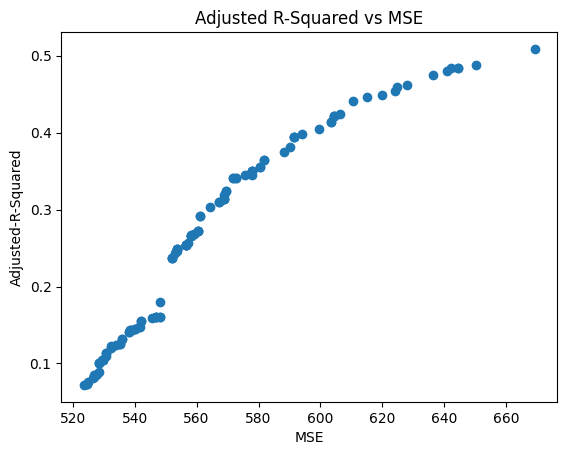

In [10]:
plt.scatter([x.values[0] for x in study.best_trials], [x.values[1] for x in study.best_trials])
plt.title("Adjusted R-Squared vs MSE")
plt.xlabel("MSE")
plt.ylabel("Adjusted-R-Squared")

In [11]:
second_derivative = np.gradient([x.values[0] for x in study.best_trials], [x.values[1] for x in study.best_trials])
minimum_derivative = min(abs(second_derivative))
minimum_index = np.where(abs(second_derivative) == minimum_derivative)
sorted_params = [x.values for x in study.best_trials]
sorted_params.sort()
best_params = study.best_trials[minimum_index[0].tolist()[0]].params
xgb_regressor = xgb.XGBRegressor(**best_params, random_state=1)
xgb_regressor.fit(hpo_inputs, hpo_data[target])

r2 = r2_score(hpo_data[target], xgb_regressor.predict(hpo_inputs))
adj_r2 = 1-(1-r2)*(hpo_inputs.shape[0]-1)/(hpo_inputs.shape[0]-hpo_inputs.shape[1]-1)
print("Retrained adj_r2 %f" % adj_r2)

divide by zero encountered in divide
divide by zero encountered in divide
invalid value encountered in add


Retrained adj_r2 0.097538


We're now ready to test our parameters on the holdout dataset.

Optimal MSE: 407.817143
Final MSE improvement: 0.334363
Final r2 score: -0.050098


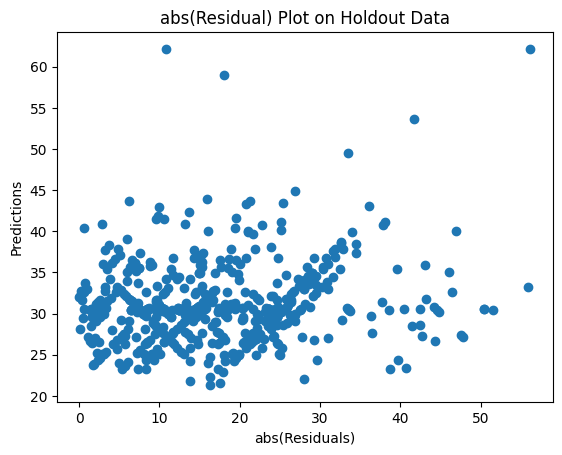

In [12]:
best_model = xgb_regressor
modelling_inputs = ohe.transform(modelling_data[features])


predictions = best_model.predict(modelling_inputs)
predictions - modelling_data[target].values
final_r2 = r2_score(modelling_data[target].values, best_model.predict(modelling_inputs))
mse_optim = mean_squared_error(modelling_data[target].values, predictions)
final_mse = abs(mse - mse_optim) / mse
print("Optimal MSE: %f" % mse_optim)
print("Final MSE improvement: %f" % final_mse)
print("Final r2 score: %f" % final_r2)
plt.scatter(abs(modelling_data[target].iloc[:,0].values - predictions), predictions)
plt.title("abs(Residual) Plot on Holdout Data")
plt.xlabel("abs(Residuals)")
plt.ylabel("Predictions")
plt.show()

Our MSE on the test set is fantastic! Unfortunately the r-squared leaves a lot to be desired, but it's not shocking as this is the test set. This means our tuned parameters are much more effective at predicting the correct answers, but the features explain less of the target variance. I've switched from adjusted-r-squared to r-squared, as the former is reliant on sample size, and we've intentionally picked a small holdout size. The absolute of residuals plot doesn't look too bad either.

Now that we've got a model that's reasonably good at predicting, we can also use our holdout dataset to understand which of our features are most influential in deciding the "p_honest" rating. We'll use the shap library (https://shap.readthedocs.io/en/latest/), which utilises Shapley values from game theory.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


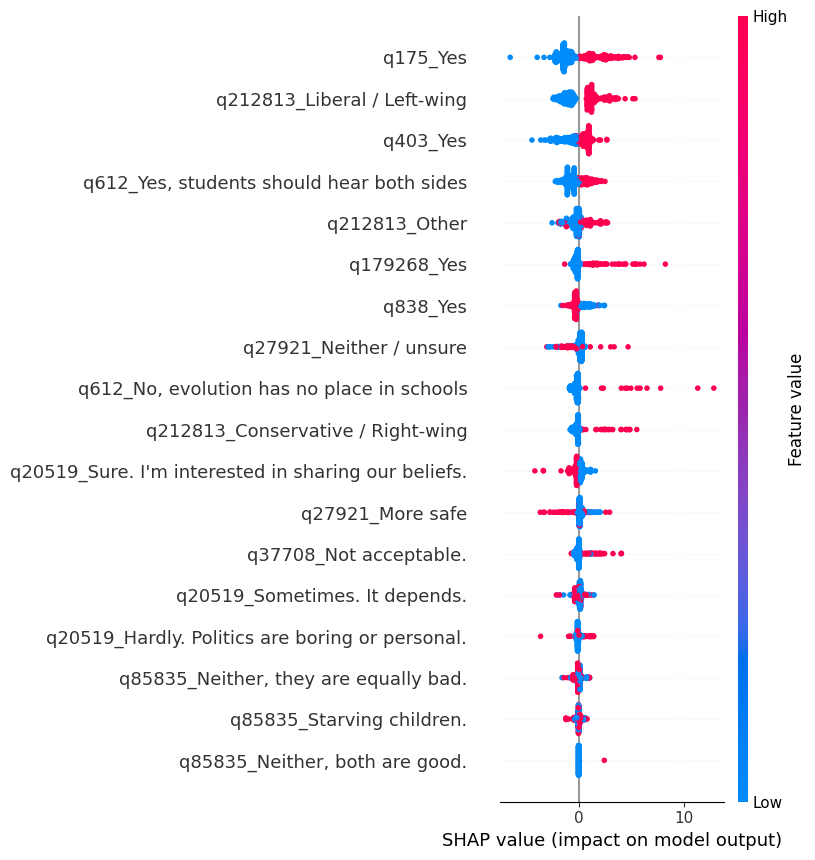

In [13]:
feature_names = modelling_data.columns
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(hpox_test)
shap.summary_plot(shap_values, hpox_test, feature_names = ohe.get_feature_names_out())


From the summary plot, it's obvious that q175 and q212813 are the most influential features on predicting "p_honest". Let's add more context to see what this actually means by looking at the questions themselves...

In [14]:
questions.loc[top_politics.index]

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q179268,Are you either vegetarian or vegan?,Yes,No,NaN,NaN,54202,O,NaN,politics; descriptive
q403,Do you enjoy discussing politics?,Yes,No,NaN,NaN,52369,O,NaN,politics; preference; descriptive
q175,Should burning your country's flag be illegal?,Yes,No,NaN,NaN,45720,O,NaN,politics
q212813,Which best describes your political beliefs?,Liberal / Left-wing,Centrist,Conservative / Right-wing,Other,45107,M,[4],politics; descriptive
q612,Should evolution and creationism be taught sid...,"Yes, students should hear both sides","No, creationism has no place in schools","No, evolution has no place in schools",NaN,44907,O,"2, 1, 3",politics; religion/superstition
q838,"For you personally, is abortion an option in c...",Yes,No,NaN,NaN,44461,O,NaN,politics; religion/superstition; opinion
q27921,Do you believe your country would be more or l...,More safe,Less safe,Neither / unsure,NaN,42307,O,"2, 3, 1",politics; opinion
q20519,In a relationship I like to discuss politics w...,All the time!,Sure. I'm interested in sharing our beliefs.,Sometimes. It depends.,Hardly. Politics are boring or personal.,40256,O,NaN,politics; preference
q85835,Which is worse: starving children or abused an...,Starving children.,Abused animals.,"Neither, both are good.","Neither, they are equally bad.",38702,O,"3, (1, 2), 4",politics; opinion
q37708,The idea of gay and lesbian couples having chi...,Acceptable.,Not acceptable.,NaN,NaN,37661,O,NaN,politics; religion/superstition; opinion


If we combine the questions with the Shapley value summaries, then we can get some interesting insights on the data! For our most influential feature, q175 ("Should burning our country's flag be illegal?"), OKCupid's "p_honest" score is higher for those than answer "Yes" than those that answer "No" in general. Similarly for the next most influential question, q212813 ("Which best describes your political beliefs?"), those that answer "Liberal / Left-wing" have higher "p_honest" scores than for those that answered "No" in general. 

Interestingly enough, it looks like answers associated with political "sides" (right/left leaning) are more related to OKCupid's "p_honest" score, such as actively identifying as conservative or liberal, questions on evolution taught in schools, and abortion.

Given all of this though, it's rather disappointing that the model only achieved an MSE of 407, given that "p_honest"'s range is between 0-100. It's obvious that quite a lot more than political questions go into the tabulation of this score. I'll expand this work by looking at cross-validation over holdout evaluation for parameter optimisation and performing feature selection on _all_ of the questions rather than just the political ones.